In [2]:
import os
import pandas as pd
import json
from typing import List
from pydantic import BaseModel

import matplotlib.pyplot as plt
import numpy as np
from constants import MODEL_NAME, ORACLE_MAPPING, QED_NAME, SIMILARITY
from predictive_metrics import score_model
from tqdm.notebook import tqdm
from utils import get_train_cs_path, ecfp, one_ecfp
from predictions import ModelProvider
from multiprocessing import Pool
from rdkit import Chem
from rdkit import DataStructs

MODELS_NAMES = sorted([MODEL_NAME])#, DATA_CONTROL])#sorted([MODEL_CONTROL, MODEL_NAME, DATA_CONTROL])
TARGET_RENAMED = {'QED_0': 'QED', 'target_1targs_power6_seed19_targid0': 'Bio-assay simulator, power 6'}
MODELS_RENAMED = {MODEL_NAME: 'Optimization'}
METERICS_RENAMED = {'proportion_active': 'Actual proportion of "active" compounds for'}

In [3]:
PLT_ALPHA = 0.75
BATCH_METRICS = ['inner_diversity']

In [4]:
SHUFFLED_MODEL_OPTIM = 'shuffled_optim'
PREDS_DICT = dict(**{m:m for m in MODELS_NAMES}, **{SHUFFLED_MODEL_OPTIM:MODEL_NAME})

In [5]:
class ExperimentResults(BaseModel):
    res_dict: dict
    chid: str
    targets: str
    tag: str
    aggregate_seeds: bool
    n_seeds: int

In [6]:
def canonicalize_smiles(smiles_list):
    molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    return [Chem.MolToSmiles(m) for m in molecules if m is not None]

In [7]:
def mol_from_smiles(smiles):
    return Chem.MolFromSmiles(smiles)

In [8]:
def mol_to_smiles(smiles):
    return Chem.MolToSmiles(smiles)

In [9]:
def canonicalize_smiles_pool(smiles_list, n_jobs=12):
    with Pool(n_jobs) as pool:
        mols = pool.map(mol_from_smiles, smiles_list)
    mols = [mol for mol in mols if mol]
    with Pool(n_jobs) as pool:
        cano_smiles = pool.map(mol_to_smiles, mols)
    return cano_smiles

In [12]:
def internal_diversity(list_fp):
    Int_div=0
    for i,fp in enumerate(list_fp):
        Int_div+=sum(DataStructs.BulkTanimotoSimilarity(fp,list_fp[i:],returnDistance=True))
    if len(list_fp) == 0:
        Int_div = 0
    else:
        Int_div=2*Int_div/len(list_fp)**2
    return Int_div

In [13]:
def __inner_diversity(smiles_list):
    ecfps = [ele for ele in [one_ecfp(smiles) for smiles in smiles_list] if ele is not None]
    return [internal_diversity(ecfps)]

In [14]:
def load_train(chid):
    chid = chid.replace('_cs', '')
    train_path = get_train_cs_path(chid)
    with open(train_path, 'r') as f:
        smiles_list = f.readlines()
    return [ele[:-1] for ele in smiles_list]

In [337]:
def get_possible_results(res_dir):
    results_dict = {}
    for chid in os.listdir(res_dir):
        results_dict[chid] = {target: os.listdir(os.path.join(res_dir, chid, target)) for target in os.listdir(os.path.join(res_dir, chid))}
    return results_dict
        
    
def __format_one_extraction(dico):
    dico_formatted = {}
    for key, list_of_list in dico.items():
        if type(list_of_list[0]) is list:
            dico_formatted[key] = list_of_list
        else:
            inner_dico_key = list(list_of_list[0].keys())[0]
            dico_formatted[key] = [ele[inner_dico_key] for ele in list_of_list]
    return dico_formatted

def __extract_results(res_dir, chid: str, target_name: str, optimizer: str, aggregate_seeds, compute_rscore: bool, compute_inner_diversity: bool):
    results = []
    base_dir = os.path.join(res_dir, chid, target_name, optimizer)
    print(f'Extracting from {base_dir}')
    n_seeds = 0
    for time_stamp in tqdm(os.listdir(base_dir)):
        print(time_stamp)
        if 'DS_Store' in time_stamp:
            continue
        if n_seeds == 15:
            break
        dir_experiment = os.path.join(base_dir, time_stamp)
        if 'results.json' in os.listdir(dir_experiment):
            formatted_res = __format_one_extraction(json.load(open(os.path.join(dir_experiment, 'results.json'), 'r')))
            if compute_rscore:
                formatted_res['rscore_pred'] = [__retro_score_list(smiles_list) for smiles_list in formatted_res['smiles']]
            if compute_inner_diversity:
                formatted_res['inner_diversity'] = [__inner_diversity(smiles_list) for smiles_list in formatted_res['smiles']]
            results.append(formatted_res)
            n_seeds += 1
    print(f'This exp has been launched {len(results)} time(s).')
    if aggregate_seeds:
        tmp_res = __format_one_extraction(results[0])
        for res_one in results[1:]:
            formatted_res_one = __format_one_extraction(res_one)
            for key, list_of_list in formatted_res_one.items():
                for idx, step_list in enumerate(list_of_list):
                    tmp_res[key][idx].extend(step_list)
        train_smiles = set(load_train(chid))
        train_cano = canonicalize_smiles(train_smiles)
        prop_intersection = []
        n_unique = []
        n_initial = []
        n_no_train = []
        for idx, smiles_list in enumerate(tmp_res['smiles'].copy()):
            n_initial.append(len(smiles_list))
            smiles_cano = canonicalize_smiles(smiles_list)
            set_smiles = set(smiles_list)
            set_cano = set(smiles_cano)
            n_unique.append(len(set_cano))
            prop_intersection_smiles = len(set_smiles.intersection(train_smiles)) / len(set_smiles)
            prop_intersection_inchi = len(set_cano.intersection(train_cano)) / len(set_cano)
            prop_intersection.append(prop_intersection_inchi)
            unique_idxs = [smiles_cano.index(s) for s in set_cano]
            for key, values in tmp_res.items():
                if key in BATCH_METRICS:
                    continue
                else:
                    tmp_res[key][idx] = [tmp_res[key][idx][unique_idx] for unique_idx in unique_idxs]
            n_no_train.append(len(unique_idxs))
        tmp_res['proportion_in_train'] = prop_intersection
        tmp_res['n_initial'] = n_initial
        tmp_res['n_unique'] = n_unique
        tmp_res['n_no_train'] = n_no_train
        
        results=[tmp_res]
    return results, n_seeds
    

def __get_batch_stats(prediction_list):
    return np.mean(prediction_list), np.std(prediction_list)

def __get_exp_recap(experiment_results_dict, target_name, target_to_plot):
    #return {model_name: [__get_batch_stats(batch_pred.get(target_name, batch_pred.get(model_name))) for batch_pred in experiment_results_dict[model_name]] for model_name in target_to_plot}
    return {model_name: [__get_batch_stats(batch_pred) for batch_pred in experiment_results_dict[model_name]] for model_name in target_to_plot}


def __add_metrics_to_res(results_dict, all_metrics_batch, model_name, repeat_idx = None) -> None:
    for metric, val_batch in all_metrics_batch.items():
        #if metric == 'proportion_active':
        #    print(metric)
        #    print(val_batch)
        if metric not in results_dict.keys():
            results_dict[metric] = {}
        if model_name not in results_dict[metric].keys():
            results_dict[metric][model_name] = []
        if repeat_idx is None:
            results_dict[metric][model_name].append(val_batch)
        else:
            if len(results_dict[metric][model_name]) <= repeat_idx:
                results_dict[metric][model_name].extend([[val_batch]])
            else:
                results_dict[metric][model_name][repeat_idx].append(val_batch)
                
                

def __get_metrics_evolution(res_exp_one, n_moving_average, target_prediction_threshold, n_shuffles, target_name, metrics_to_plot):
    oracle_binned_names = [targ for targ in res_exp_one.keys() if ORACLE_MAPPING.get(target_name, target_name) in targ and 'binned' in targ]
    print(len(oracle_binned_names))
    if len(oracle_binned_names) == 0:
        return None
    oracle_binned_name = oracle_binned_names[0]
    oracle_batches_values = res_exp_one[oracle_binned_name]
    results_dict = {}
    random_res_dict = {}
    for metric in metrics_to_plot:
        if metric in res_exp_one.keys():
            print(f'{metric} IN')
            for batch in res_exp_one[metric]:
                __add_metrics_to_res(results_dict, {metric: np.mean(batch)}, MODELS_NAMES[0])
        else:
            print(f'{metric} OUT')
    for idx in range(len(oracle_batches_values) - n_moving_average):
        for model_name in MODELS_NAMES + [SHUFFLED_MODEL_OPTIM]:
            batch_pred_concatenated = 1 * np.hstack([list_rescored for list_rescored in res_exp_one[PREDS_DICT[model_name]][idx: idx+n_moving_average]])
            batch_oracle_concat = 1 * np.hstack([ele for ele in oracle_batches_values[idx: idx+n_moving_average]])
            if model_name != SHUFFLED_MODEL_OPTIM:
                all_metrics_batch = score_model(batch_oracle_concat, batch_pred_concatenated, target_prediction_threshold)
                __add_metrics_to_res(results_dict, all_metrics_batch, model_name)
            else:
                for k in range(n_shuffles):
                    all_metrics_batch = score_model(
                        batch_oracle_concat,
                        np.random.choice(batch_pred_concatenated, len(batch_pred_concatenated)),
                        target_prediction_threshold
                    )
                    __add_metrics_to_res(results_dict, all_metrics_batch, model_name, idx)
                
    return results_dict


def __plot_one_score_evolution(exp_results: List[ExperimentResults], title, metrics_dict, target_name, savefig):
    targets_to_plot = MODELS_NAMES
    plt.figure(figsize=(14,7))
    legend = []
    print(targets_to_plot, len(exp_results))
    for model_name in targets_to_plot:
        for experiment_result in exp_results:   
            res_exp_one = __get_exp_recap(experiment_result.res_dict, target_name, targets_to_plot)
            list_res = res_exp_one[model_name]
            mean_list = [ele[0] for ele in list_res]
            std_list = [ele[1] for ele in list_res]
            x = list(range(len(list_res)))
            plt.errorbar(x, mean_list, yerr = std_list, alpha=PLT_ALPHA)
            legend.append(experiment_result.tag)
#    legend = [MODELS_RENAMED.get(targ, targ) for targ in targets_to_plot]
    plt.ylabel('Prediction score')
    plt.xlabel('Step')
    if 'prediction_threshold' in metrics_dict:
        plt.axhline(metrics_dict['prediction_threshold'], c='r', linestyle='--', alpha=0.5)
        legend.insert(0, 'Classifier prediction threshold')
    plt.legend(legend)
    plt.title(title)
    plt.ylim([0, 1])
    if savefig:
        plt.savefig(f'{savefig}_{target_name}_preds.png')

    plt.show()
    

def __plot_criteria(exp_results: List[ExperimentResults], criteria, savefig, chid):
    plt.figure(figsize=(14,7))
    legend = []
    for experiment_results in exp_results:
        res_exp_one = __get_exp_recap(experiment_results.res_dict, criteria, [criteria])
        list_res = res_exp_one[criteria]
        mean_list = [ele[0] for ele in list_res]
        std_list = [ele[1] for ele in list_res]
        x = list(range(len(list_res)))
        plt.errorbar(x, mean_list, yerr = std_list, alpha=PLT_ALPHA)
        legend.append(experiment_results.tag)
    plt.legend(legend)
    plt.ylabel(criteria)
    plt.xlabel('Step')
    plt.title(f'{criteria} evolution')
    plt.ylim([0, 1])
    if savefig:
        plt.savefig(f'{savefig}_{criteria}.png')
    plt.show()
    
    
def __plot_perfs_evolution(exp_results: List[ExperimentResults], title, n_moving_average, metrics_dict, n_shuffles, target_name, metrics_to_plot, savefig):
    prediction_threshold = metrics_dict['prediction_threshold']
    res_metrics_list = [__get_metrics_evolution(experiment_results.res_dict, n_moving_average, prediction_threshold, n_shuffles, target_name, metrics_to_plot) for experiment_results in exp_results]
    #print(50*'--')
    #print(target_name)
    #print(metrics_to_plot)
    #for key, val in res_metrics_list[0].items():
        #print(key, type(val))
        #print(len(val['model_for_optim']))
        #print(val['model_for_optim'])

    if None in res_metrics_list:
        return None
    legend = []
    for metric_name in metrics_to_plot:
        plt.figure(figsize=(14,7))
        for idx, experiment_results in enumerate(exp_results):
            metric_values = res_metrics_list[idx][metric_name]

            for model_name in sorted(metric_values.keys()):
                list_res = metric_values[model_name]
                #if metric_name == "proportion_active":
                #    print(len(list_res))
                #    print(type(list_res[0]))
                x = list(range(len(list_res)))
                if model_name != SHUFFLED_MODEL_OPTIM:
                    plt.plot(x, list_res, 'x', linestyle='-', alpha=PLT_ALPHA)
                else:
                    continue
                    list_res = [__get_batch_stats(metric_one) for metric_one in list_res]
                    mean_list = [ele[0] for ele in list_res]
                    std_list = [ele[1] for ele in list_res]
                    plt.errorbar(x, mean_list, yerr = std_list, alpha=PLT_ALPHA)
            legend.append(experiment_results.tag)
        plt.ylabel(f'{metric_name}')
        plt.xlabel('Step')
        if metric_name in metrics_dict:
            plt.axhline(metrics_dict[metric_name], c='r', linestyle='--', alpha=0.5)
        plt.title(f'{METERICS_RENAMED.get(metric_name, metric_name)} {title}')
        plt.legend(legend + ['Initial data baseline'])
#        plt.legend([MODELS_RENAMED.get(leg, leg) for leg in sorted(metric_values.keys()) if leg!= SHUFFLED_MODEL_OPTIM] + ['Initial data baseline'])
        y_max = plt.gca().get_ylim()[1]
        if y_max < 1.5:
            plt.ylim([0, 1])
        if savefig:
            plt.savefig(f'{savefig}_{metric_name}.png')
        plt.show()
        
def run_plot(exp_results: List[ExperimentResults], chid, targets, target_name: str, optimizer: str, n_moving_average, metrics_dict, n_shuffles=1, metrics_to_plot=['proportion_active'], compute_rscore=False, savedir=None):
    savefig=None
    if savedir:
        savefig = os.path.join(savedir, f'{optimizer}_{chid}_{targets}')
    n_seeds = exp_results[0].n_seeds
    aggregate_seeds = exp_results[0].aggregate_seeds
#    __plot_one_score_evolution(exp_results, f'{TARGET_RENAMED.get(target_name, target_name)} prediction scores optimized with {optimizer}, dataset {chid} \n {idx if not aggregate_seeds else n_seeds} seeds', metrics_dict, target_name, savefig)
    __plot_one_score_evolution(exp_results, f'{TARGET_RENAMED.get(target_name, target_name)} prediction scores \n {idx if not aggregate_seeds else n_seeds} seeds', metrics_dict, target_name, savefig)
    for criteria in [QED_NAME, SIMILARITY] + compute_rscore * ['rscore_pred']:
        if criteria in exp_results[0].res_dict.keys():
            __plot_criteria(exp_results, criteria, savefig, chid)
    # __plot_perfs_evolution(exp_results, f'{TARGET_RENAMED.get(target_name, target_name)}  (optimized with {optimizer}, dataset {chid}) \n {idx if not aggregate_seeds else n_seeds} seeds', n_moving_average, metrics_dict, n_shuffles, target_name, metrics_to_plot, savefig)
    __plot_perfs_evolution(exp_results, f'{TARGET_RENAMED.get(target_name, target_name)} ', n_moving_average, metrics_dict, n_shuffles, target_name, metrics_to_plot, savefig)
        

In [16]:
def get_stats(results, key, target_name):
    mean_list=[]
    std_list=[]
    for list_of_list in results[key]:
        mean_one, std_one = __get_batch_stats(list_of_list)
        mean_list.append(mean_one)
        std_list.append(std_one)
    return mean_list, std_list

In [17]:
def __stack_plots_one(res_all, key, target_name, title_prefix):
    plt.figure(figsize=(14,8))
    for res in res_all:
        means, stds = get_stats(res, key, target_name)
        plt.errorbar(list(range(1, len(means)+1)), means, yerr = np.array(stds)/2)
    plt.title(f'{title_prefix} \n {target_name} evolution')
    plt.xlabel('GA Step')
    plt.ylabel(target_name)
    
    plt.show()
    

def stack_plots_all(res_all, dico_mapping, title_prefix):
    for key, target_name in dico_mapping.items():
        __stack_plots_one(res_all, key, target_name, title_prefix)

# Stack plots

In [18]:
from create_oracle import _extract_params_from_target_name

In [19]:
def rename_target(target: str):
    if target == 'QED_0':
        return 'QED'
    
    n_targs, power, seed = _extract_params_from_target_name(target)
    return f'Simulator {power}'

In [20]:
def get_tag(chid, target, stack_chids, stack_targets):
    chid_name = chid
    targets = target.split('_SEP_')
    #base_target = rename_target(targets[0])
    base_target = ''
    if len(stack_chids) > 1:
        if '_cs' in chid:
             chid_name = f'{chid.split("cs")[0][:-1]} (from CS)'
    if len(stack_targets) > 1:
        if len(targets) > 1:
            base_target = f'{base_target}, w simi'

    return f'{chid_name}{base_target}'

In [327]:
res_dir = 'results/'

common_chids = ['irak4_bayer', 'irak4_merck', 'irak4_pfizer', 'irak4_roche']
optimizer = 'graph_ga'

CS_suffix = '_cs'
simi_suffix = '_SEP_similarity'
QED = 'QED_0'
QED_simi = QED + simi_suffix
t6 = 'target_1targs_power6_seed19_targid0'
t6_simi = t6 + simi_suffix
t15 = 'target_1targs_power15_seed19_targid0'
t15_simi = t15 + simi_suffix

In [328]:
exp_stack = [
#    (common_chids, [QED]),
#] + [
#    ([chid], [QED, QED_simi]) for chid in common_chids
#]  + [
#    ([chid, chid+CS_suffix], [QED_simi]) for chid in common_chids
#] + [
    ([chid, chid+CS_suffix], [t6, t6_simi]) for chid in common_chids
]  + [
#    ([chid, chid+CS_suffix], [t6_simi]) for chid in common_chids
#] + [
#   ([chid, chid+CS_suffix], [t15, t15_simi]) for chid in common_chids
#]  + [
#    ([chid, chid+CS_suffix], [t15_simi]) for chid in common_chids
]

In [329]:
exp_stack = [
    ([chid, chid+CS_suffix], [t6_simi]) for chid in common_chids
]

In [330]:
for chid_list, stacked_target in exp_stack:
    for chid in chid_list:
        for targ in stacked_target:
            print(chid, targ, chid_list, stacked_target)
            print(get_tag(chid, targ, chid_list, stacked_target))

irak4_bayer target_1targs_power6_seed19_targid0_SEP_similarity ['irak4_bayer', 'irak4_bayer_cs'] ['target_1targs_power6_seed19_targid0_SEP_similarity']
irak4_bayer
irak4_bayer_cs target_1targs_power6_seed19_targid0_SEP_similarity ['irak4_bayer', 'irak4_bayer_cs'] ['target_1targs_power6_seed19_targid0_SEP_similarity']
irak4_bayer (from CS)
irak4_merck target_1targs_power6_seed19_targid0_SEP_similarity ['irak4_merck', 'irak4_merck_cs'] ['target_1targs_power6_seed19_targid0_SEP_similarity']
irak4_merck
irak4_merck_cs target_1targs_power6_seed19_targid0_SEP_similarity ['irak4_merck', 'irak4_merck_cs'] ['target_1targs_power6_seed19_targid0_SEP_similarity']
irak4_merck (from CS)
irak4_pfizer target_1targs_power6_seed19_targid0_SEP_similarity ['irak4_pfizer', 'irak4_pfizer_cs'] ['target_1targs_power6_seed19_targid0_SEP_similarity']
irak4_pfizer
irak4_pfizer_cs target_1targs_power6_seed19_targid0_SEP_similarity ['irak4_pfizer', 'irak4_pfizer_cs'] ['target_1targs_power6_seed19_targid0_SEP_simil

In [225]:
exp_stack

[(['irak4_merck', 'irak4_merck_cs'],
  ['target_1targs_power6_seed19_targid0_SEP_similarity']),
 (['irak4_roche', 'irak4_roche_cs'],
  ['target_1targs_power6_seed19_targid0_SEP_similarity'])]

In [333]:
def get_stacked_experiments(stack_chids: list, stack_targets, aggregate_seeds=True, res_dir=res_dir):
    exp_list = []
    for chid in stack_chids:
        for targ in stack_targets:
            tag = get_tag(chid, targ, stack_chids, stack_targets)
            print(chid, stack_chids, tag)
            res_dict, n_seeds =__extract_results(res_dir, chid, targ, 'graph_ga', compute_rscore=False, aggregate_seeds=aggregate_seeds, compute_inner_diversity=True)
            exp_list.append(
                ExperimentResults(
                    res_dict=res_dict[0],
                    chid=chid,
                    targets=targ,
                    tag=get_tag(chid, targ, stack_chids, stack_targets),
                    aggregate_seeds=aggregate_seeds,
                    n_seeds=n_seeds
                )
            )
    return exp_list
    

In [334]:
model_provider.get_model_optim_metrics()

{'prediction_threshold': 0.48,
 'mae': 0.43727626459143965,
 'precision': 0.6640625,
 'recall': 0.6204379562043796,
 'proportion_active': 0.5330739299610895,
 'auc': 0.6687347931873481,
 'pr_auc': 0.6776792012465606,
 'kappa': 0.2608906245269882,
 'accuracy': 0.6303501945525292,
 'f1_score': 0.6415094339622641,
 'log_loss': 0.672292538668316,
 'brier_score_loss': 0.23612996108949416,
 'expected_calibration_error': 0.08926070038910505,
 'maximum_calibration_error': 0.3036363636363636,
 'uncertainty_auc': 0.5748538011695907,
 'normalized precision': 1.2457230839416058}

['irak4_bayer', 'irak4_bayer_cs'] ['target_1targs_power6_seed19_targid0_SEP_similarity']
irak4_bayer ['irak4_bayer', 'irak4_bayer_cs'] irak4_bayer
Extracting from ndr_211013/irak4_bayer/target_1targs_power6_seed19_targid0_SEP_similarity/graph_ga


2021-10-13_18-48-06
2021-10-13_18-36-41
.DS_Store
2021-10-13_17-40-30
2021-10-13_19-21-29
2021-10-13_18-14-35
2021-10-13_18-03-00
2021-10-13_17-29-45
2021-10-13_18-25-55
2021-10-13_19-10-22
2021-10-13_16-45-27
2021-10-13_17-06-41
2021-10-13_16-56-09
2021-10-13_18-59-26
2021-10-13_17-52-08
2021-10-13_17-18-14

This exp has been launched 15 time(s).
irak4_bayer_cs ['irak4_bayer', 'irak4_bayer_cs'] irak4_bayer (from CS)
Extracting from ndr_211013/irak4_bayer_cs/target_1targs_power6_seed19_targid0_SEP_similarity/graph_ga


2021-10-13_18-36-40
2021-10-13_17-40-30
2021-10-13_19-21-29
2021-10-13_18-14-35
2021-10-13_17-29-44
2021-10-13_19-10-22
2021-10-13_18-25-54
2021-10-13_18-48-05
2021-10-13_17-06-40
2021-10-13_16-56-08
2021-10-13_16-45-27
2021-10-13_18-59-26
2021-10-13_17-52-08
2021-10-13_18-02-59
2021-10-13_17-18-13

This exp has been launched 15 time(s).
['model_for_optim'] 2


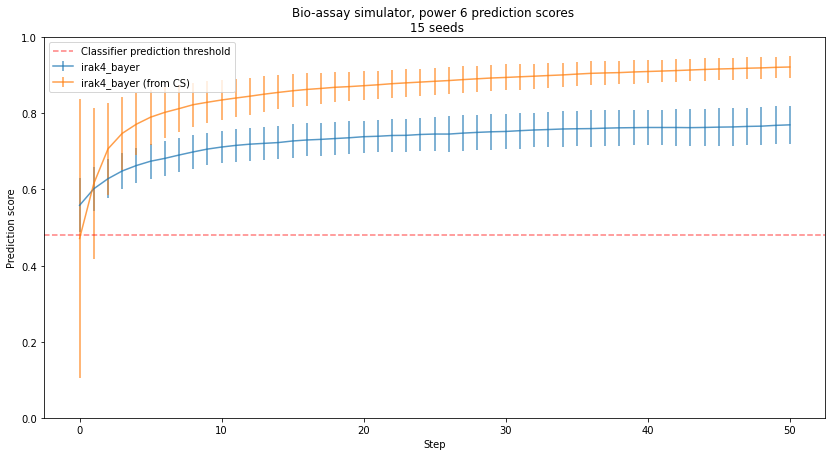

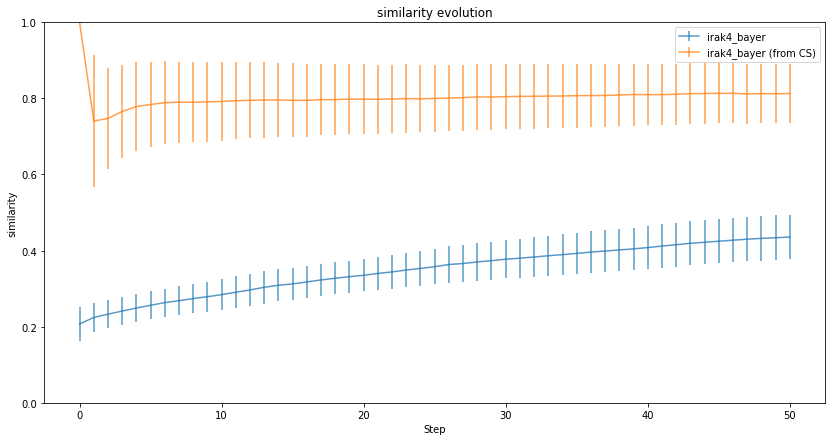

0
0
['irak4_merck', 'irak4_merck_cs'] ['target_1targs_power6_seed19_targid0_SEP_similarity']
irak4_merck ['irak4_merck', 'irak4_merck_cs'] irak4_merck
Extracting from ndr_211013/irak4_merck/target_1targs_power6_seed19_targid0_SEP_similarity/graph_ga


2021-10-13_17-24-06
2021-10-13_17-12-29
2021-10-13_19-05-19
2021-10-13_18-42-13
2021-10-13_17-01-08
2021-10-13_18-08-49
2021-10-13_19-15-59
2021-10-13_17-46-34
2021-10-13_18-31-36
2021-10-13_19-27-04
2021-10-13_17-34-59
2021-10-13_18-20-01
2021-10-13_17-57-38
2021-10-13_16-50-34
2021-10-13_18-53-50

This exp has been launched 15 time(s).
irak4_merck_cs ['irak4_merck', 'irak4_merck_cs'] irak4_merck (from CS)
Extracting from ndr_211013/irak4_merck_cs/target_1targs_power6_seed19_targid0_SEP_similarity/graph_ga


2021-10-13_18-31-35
2021-10-13_17-12-28
2021-10-13_19-05-18
2021-10-13_18-42-13
2021-10-13_17-01-08
2021-10-13_19-15-58
2021-10-13_18-08-47
2021-10-13_17-46-33
2021-10-13_17-24-05
2021-10-13_19-27-04
2021-10-13_17-34-59
2021-10-13_18-20-00
2021-10-13_17-57-38
2021-10-13_16-50-34
2021-10-13_18-53-50

This exp has been launched 15 time(s).
['model_for_optim'] 2


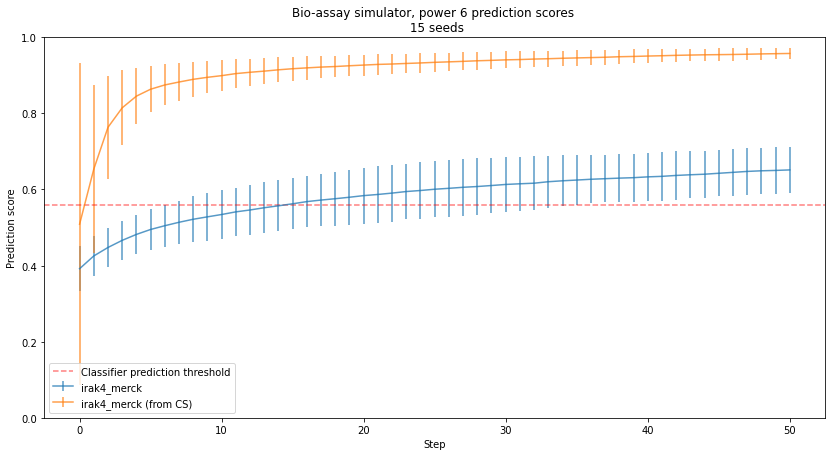

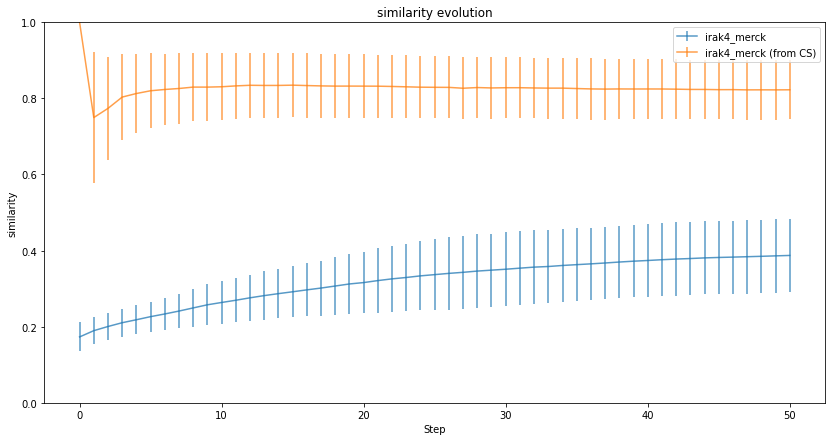

0
0
['irak4_pfizer', 'irak4_pfizer_cs'] ['target_1targs_power6_seed19_targid0_SEP_similarity']
MODEL DOES NOT EXIST, TRAINING
Reading data from: ./assays/processed/irak4_pfizer.csv
TRAINING DONE
irak4_pfizer ['irak4_pfizer', 'irak4_pfizer_cs'] irak4_pfizer
Extracting from ndr_211013/irak4_pfizer/target_1targs_power6_seed19_targid0_SEP_similarity/graph_ga


2021-10-13_18-19-54
2021-10-13_16-50-15
2021-10-13_17-12-29
2021-10-13_17-01-31
2021-10-13_18-08-37
2021-10-13_18-42-37
2021-10-13_19-27-25
2021-10-13_17-23-47
2021-10-13_17-46-13
2021-10-13_18-53-29
2021-10-13_18-31-01
2021-10-13_17-57-14
2021-10-13_17-35-18
2021-10-13_19-16-20
2021-10-13_19-04-38

This exp has been launched 15 time(s).
irak4_pfizer_cs ['irak4_pfizer', 'irak4_pfizer_cs'] irak4_pfizer (from CS)
Extracting from ndr_211013/irak4_pfizer_cs/target_1targs_power6_seed19_targid0_SEP_similarity/graph_ga


2021-10-13_16-50-14
2021-10-13_18-19-53
2021-10-13_17-12-28
2021-10-13_18-08-36
2021-10-13_17-01-30
2021-10-13_18-42-37
2021-10-13_19-27-25
2021-10-13_17-23-46
2021-10-13_18-31-00
2021-10-13_17-46-13
2021-10-13_18-53-29
2021-10-13_17-57-14
2021-10-13_19-16-19
2021-10-13_17-35-17
2021-10-13_19-04-38

This exp has been launched 15 time(s).
['model_for_optim'] 2


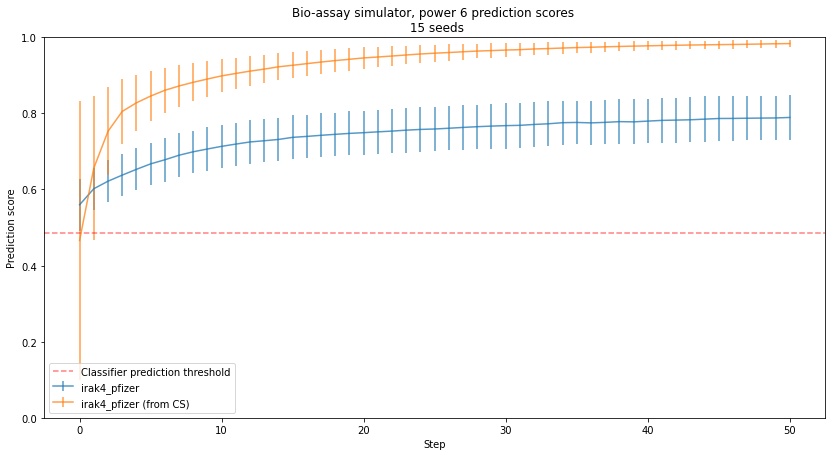

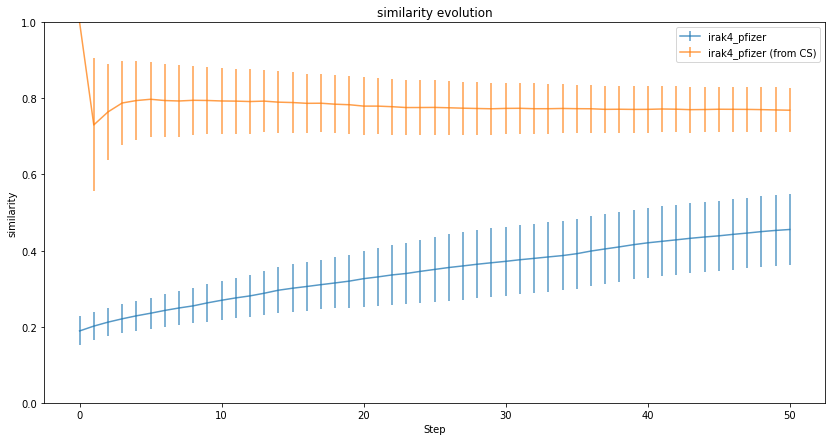

0
0
['irak4_roche', 'irak4_roche_cs'] ['target_1targs_power6_seed19_targid0_SEP_similarity']
irak4_roche ['irak4_roche', 'irak4_roche_cs'] irak4_roche
Extracting from ndr_211013/irak4_roche/target_1targs_power6_seed19_targid0_SEP_similarity/graph_ga


2021-10-13_18-48-00
2021-10-13_19-10-43
2021-10-13_17-41-00
2021-10-13_18-25-32
2021-10-13_16-45-49
2021-10-13_18-59-07
2021-10-13_19-21-51
2021-10-13_18-03-00
2021-10-13_17-18-11
2021-10-13_17-07-04
2021-10-13_17-51-47
2021-10-13_18-14-08
2021-10-13_17-29-15
2021-10-13_16-55-32
2021-10-13_18-37-02

This exp has been launched 15 time(s).
irak4_roche_cs ['irak4_roche', 'irak4_roche_cs'] irak4_roche (from CS)
Extracting from ndr_211013/irak4_roche_cs/target_1targs_power6_seed19_targid0_SEP_similarity/graph_ga


2021-10-13_18-48-00
2021-10-13_19-10-43
2021-10-13_17-41-00
2021-10-13_18-25-32
2021-10-13_16-45-48
2021-10-13_18-59-07
2021-10-13_19-21-50
2021-10-13_18-37-01
2021-10-13_17-07-04
2021-10-13_17-18-10
2021-10-13_17-51-46
2021-10-13_18-14-08
2021-10-13_17-29-15
2021-10-13_16-55-32
2021-10-13_18-02-59

This exp has been launched 15 time(s).
['model_for_optim'] 2


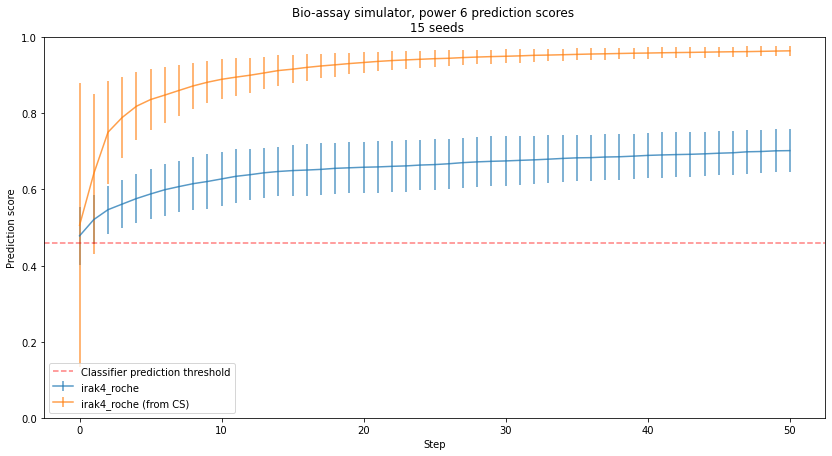

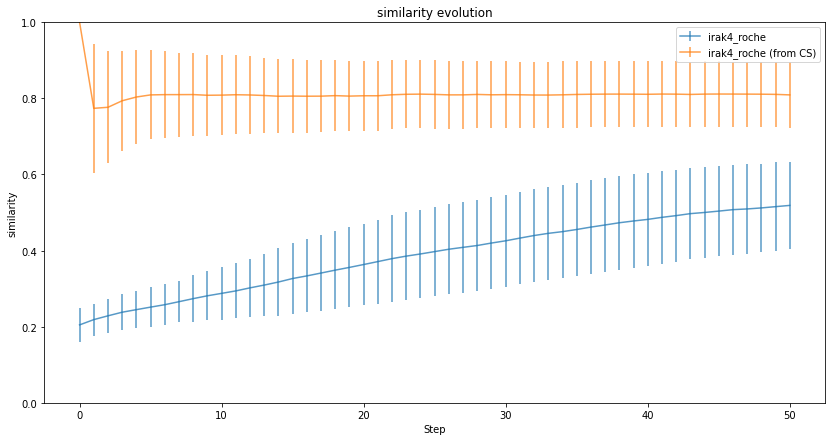

0
0


In [338]:
list_exp = []
for stacked_chids, stacked_targets in exp_stack:
#    try:
    print(stacked_chids, stacked_targets)
    target = stacked_targets[0].split('_SEP_')[0]
    model_provider = ModelProvider(stacked_chids[0], target)
    metrics = model_provider.get_model_optim_metrics()
    list_exp.append(get_stacked_experiments(stacked_chids, stacked_targets, aggregate_seeds=True))
    run_plot(list_exp[-1], stacked_chids[0], stacked_targets[0], target, optimizer, 2, metrics, 5, metrics_to_plot=['proportion_active', 'proportion_in_train', 'inner_diversity'], compute_rscore=False, savedir=None)
#    except Exception as e:
#        list_exp.append([])
#        print(e)

In [339]:
len(list_exp)

4

In [216]:
experiment_res = list_exp[0]

In [234]:
print(len(experiment_res))
res_dict = experiment_res[1].res_dict
res_dict.keys()

2


dict_keys(['smiles', 'model_for_optim', 'model_control', 'data_control', 'model_rescorer', 'similarity', 'inner_diversity', 'proportion_in_train', 'n_initial', 'n_unique', 'n_no_train'])

In [218]:
print(len(res_dict['model_rescorer']))
print(len(res_dict['model_rescorer'][0]))
print(res_dict['model_for_optim'][0][:10])
print(res_dict['model_control'][0][:10])
print(res_dict['model_rescorer'][0][:10])
print(res_dict['data_control'][0][:10])

51
80
[0.72, 0.99, 0.99, 0.16, 1.0, 0.97, 0.0, 0.02, 0.23, 0.91]
[0.8, 0.97, 0.98, 0.15, 0.99, 0.93, 0.0, 0.06, 0.12, 0.95]
[0.37081920501231375, 0.8299276998649207, 0.7194360102978506, 0.4161672604949341, 0.8375319413865896, 0.8051424946458396, 0.07581188324971186, 0.39183032784492694, 0.4898492520138339, 0.5984346708666369]
[0.69, 0.56, 0.55, 0.04, 0.94, 0.61, 0.01, 0.17, 0.43, 0.97]


In [207]:
# behavior accross seeds
experiment_res[0].n_seeds

1

In [84]:
# TODO: merge this with the code which retrieve list_exp above
exp_ids = exp_stack[0][0]
print(exp_ids)

['irak4_merck', 'irak4_merck_cs']


In [232]:
len(list_exp)

2

In [343]:
# Let's selection a set of best mols
scores = ['model_for_optim', 'model_control', 'data_control', 'model_rescorer', 'similarity']
df_exp_dict = {}
col_to_exclude = ['inner_diversity', 'proportion_in_train', 'n_initial', 'n_unique', 'n_no_train']

for i, (stacked_chids, _) in enumerate(exp_stack):
    for exp, exp_name in zip(list_exp[i], stacked_chids):
        res_dict = exp.res_dict
        columns = [c for c in res_dict.keys() if c not in col_to_exclude]
        df_exp = pd.DataFrame()
        for i in range(len(res_dict[scores[0]])):
            df_iter = pd.DataFrame(list(np.array([res_dict[col][i] for col in columns]).T), columns=columns)
            df_iter['step'] = i
            df_exp = df_exp.append(df_iter)
        df_exp[scores] = df_exp[scores].astype(float)
        # formatting oracle columns
        str2bool = {'True': True, 'False': False}
        for col in df_exp.columns:
            if 'binned' in col:
                df_exp[col] = df_exp[col].map(str2bool)
        df_exp_dict[exp_name] = df_exp

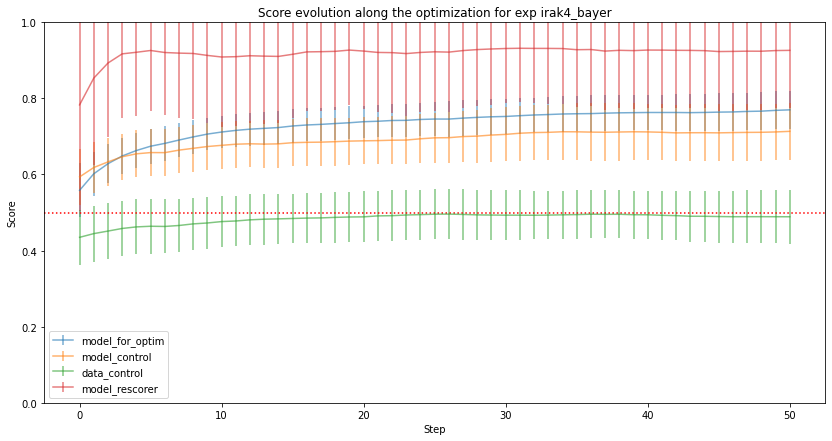

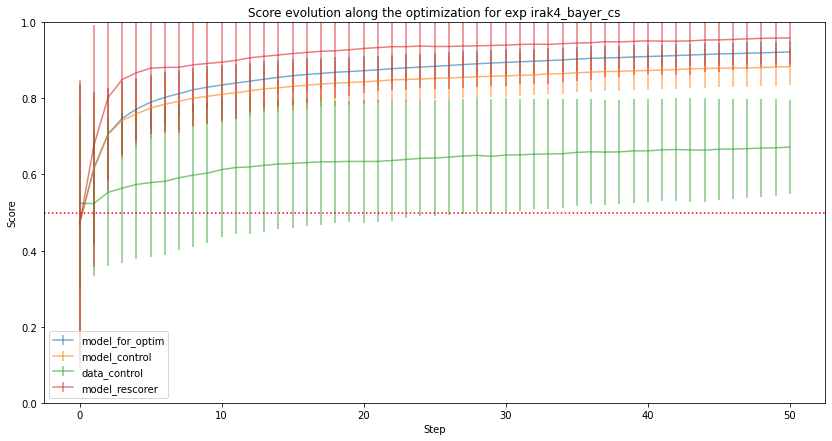

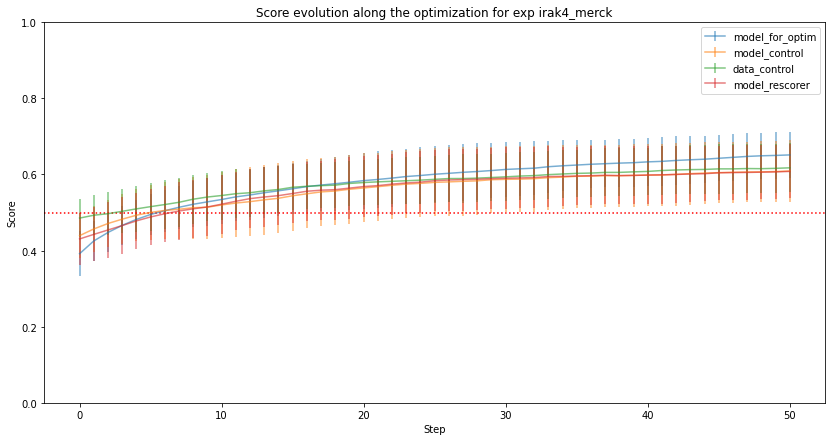

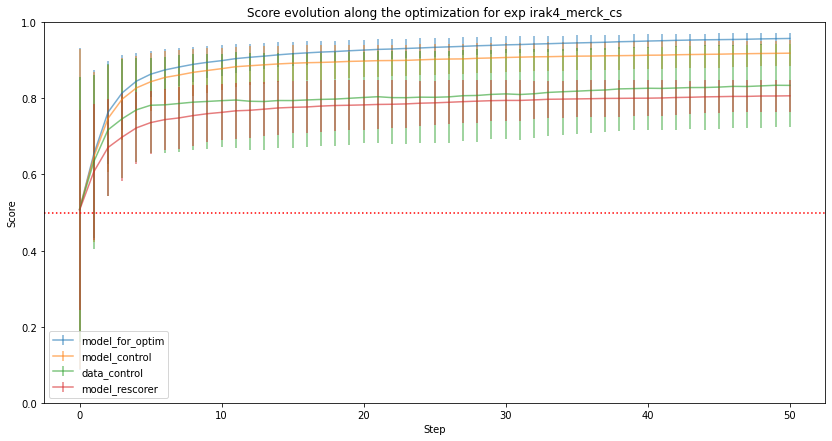

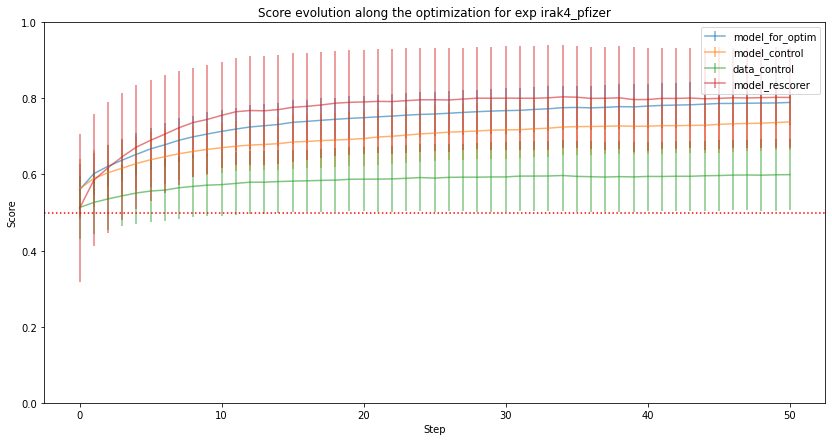

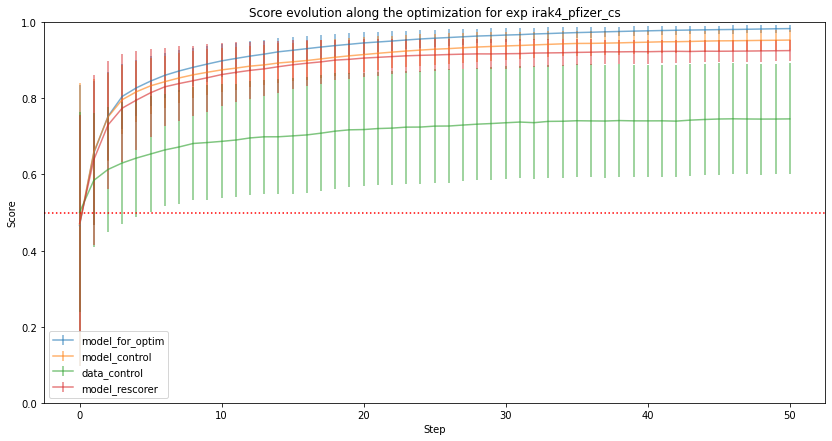

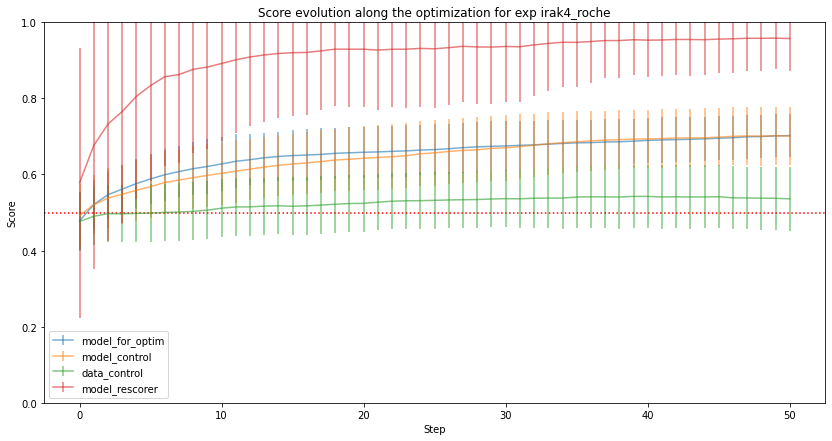

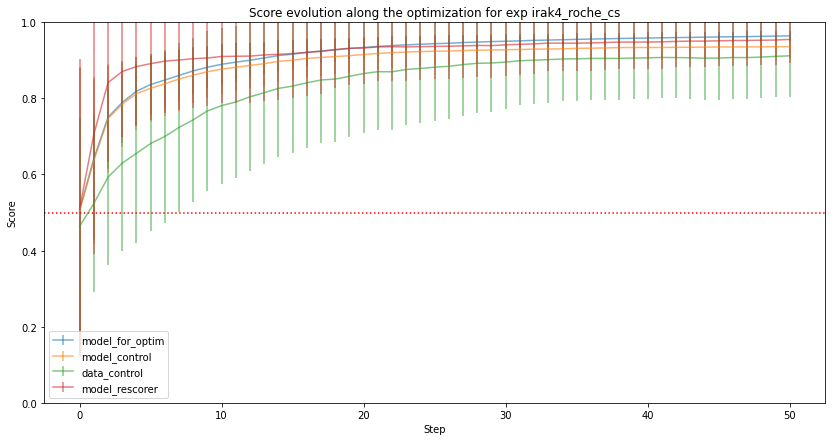

In [344]:
# Checking we get the same plot

for exp_name , df_exp in df_exp_dict.items():
    plt.figure(figsize=(14,7))
    for score in ['model_for_optim', 'model_control', 'data_control', 'model_rescorer']:
        mean = df_exp.groupby('step')[score].mean()
        std = df_exp.groupby('step')[score].std()
        plt.errorbar(np.arange(len(mean)), mean, yerr = std, alpha=0.6, label=score)

    plt.ylim(0, 1)
    plt.legend()
    plt.axhline(0.5, c='r', linestyle=':')
    plt.ylabel('Score')
    plt.xlabel('Step')
    plt.title(f'Score evolution along the optimization for exp {exp_name}')
    plt.show()

In [280]:
# TODO: add plot for final selection evaluation 
exp_names = list(df_exp_dict.keys())
print(exp_names)
df_exp = df_exp_dict[exp_names[2]]

rescorer_col = 'data_control'
rescorer_thresh = 0.5
selection = df_exp[df_exp[rescorer_col] >= rescorer_thresh]
print(f'Size of selection {len(selection)} / {len(df_exp)}')

['irak4_merck', 'irak4_merck_cs', 'irak4_roche', 'irak4_roche_cs']
Size of selection 2068 / 5099


In [265]:
selection.columns

Index(['smiles', 'model_for_optim', 'model_control', 'data_control',
       'model_rescorer', 'oracle_raw_target_1targs_power6_seed19_targid0',
       'oracle_binned_target_1targs_power6_seed19_targid0', 'similarity',
       'step'],
      dtype='object')

In [308]:
np.linspace(0, 0.99, 20)

array([0.        , 0.05210526, 0.10421053, 0.15631579, 0.20842105,
       0.26052632, 0.31263158, 0.36473684, 0.41684211, 0.46894737,
       0.52105263, 0.57315789, 0.62526316, 0.67736842, 0.72947368,
       0.78157895, 0.83368421, 0.88578947, 0.93789474, 0.99      ])

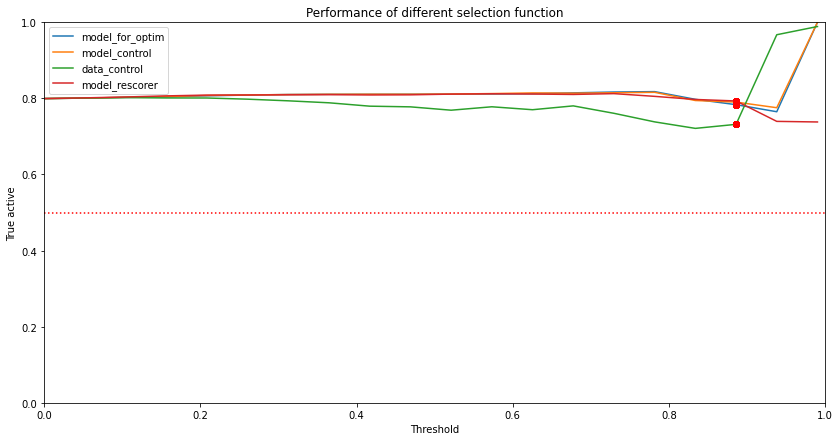

In [309]:
threshs = np.linspace(0, 0.99, 20)
oracle = 'oracle_binned_target_1targs_power6_seed19_targid0'

rescorings = {
    score: [(df_exp[df_exp[score] >= rescorer_thresh])[oracle].mean() for rescorer_thresh in threshs] 
              for score in ['model_for_optim', 'model_control', 'data_control', 'model_rescorer']
}
# Add the plot ratio of active w.r.t threshold of selection 
plt.figure(figsize=(14,7))

for selector_label, selector_values in rescorings.items():
    plt.plot(threshs, selector_values, label=selector_label)
    for ix, threshold in enumerate(threshs):
        pos = 1
        if not np.isnan(selector_values[idx]):
            plt.plot(threshs[idx], selector_values[idx], 'ro')
#            plt.text(
#                threshs[idx],
#                selector_values[idx] + pos * 0.06,
#                f'{round(selector_values[idx], 2)}',
#                size=12,
#                ha='center',
#                va='center',
#            )
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.axhline(0.5, c='r', linestyle=':')
plt.ylabel('True active')
plt.xlabel('Threshold')
plt.title('Performance of different selection function')
plt.show()

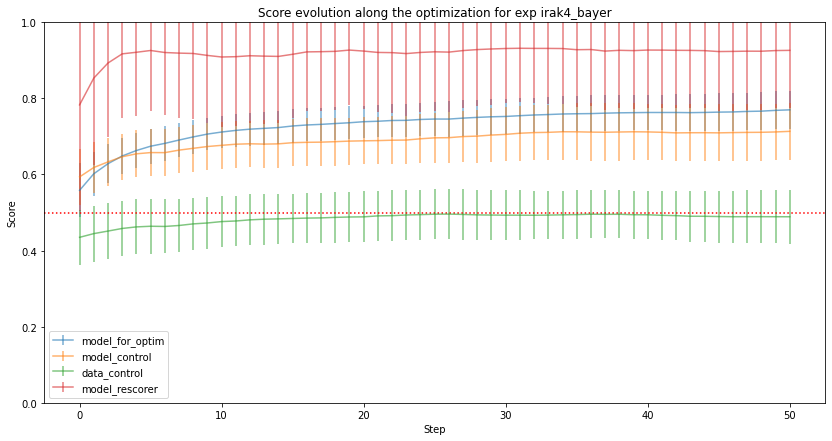

KeyError: 'oracle_binned_target_1targs_power6_seed19_targid0'

<Figure size 1008x504 with 0 Axes>

In [345]:
# All plots

# Checking we get the same plot
oracle = 'oracle_binned_target_1targs_power6_seed19_targid0'

for exp_name , df_exp in df_exp_dict.items():
    plt.figure(figsize=(14,7))
    for score in ['model_for_optim', 'model_control', 'data_control', 'model_rescorer']:
        mean = df_exp.groupby('step')[score].mean()
        std = df_exp.groupby('step')[score].std()
        plt.errorbar(np.arange(len(mean)), mean, yerr = std, alpha=0.6, label=score)

    plt.ylim(0, 1)
    plt.legend()
    plt.axhline(0.5, c='r', linestyle=':')
    plt.ylabel('Score')
    plt.xlabel('Step')
    plt.title(f'Score evolution along the optimization for exp {exp_name}')
    plt.show()

    # Add the plot ratio of active w.r.t threshold of selection 
    plt.figure(figsize=(14,7))
    for selector_label in ['model_for_optim', 'model_control', 'data_control', 'model_rescorer']:
        selector_values = [(df_exp[df_exp[selector_label] >= rescorer_thresh])[oracle].mean() for rescorer_thresh in threshs] 
        plt.plot(threshs, selector_values, label=selector_label)
    plt.legend()
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.axhline(0.5, c='r', linestyle=':')
    plt.ylabel('True active')
    plt.xlabel('Threshold')
    plt.title(f'Performance of different selection function for exp {exp_name}')
    plt.show()
    
    # Number of mols selected 
    for selector_label in ['model_for_optim', 'model_control', 'data_control', 'model_rescorer']:
        selector_values = [(df_exp[selector_label] >= rescorer_thresh).sum() for rescorer_thresh in threshs] 
        plt.plot(threshs, selector_values, label=selector_label)
    plt.legend()
    plt.xlim(0, 1)
    plt.ylabel('Size of selection')
    plt.xlabel('Threshold')
    plt.title(f'Size of selection of different selection function for exp {exp_name}')
    plt.show()


## Reading raw results

In [238]:
res_dir = 'results/'
chid = 'irak4_roche_cs'
target_name = 'target_1targs_power6_seed19_targid0' + simi_suffix
optimizer = 'graph_ga'

base_dir = os.path.join(res_dir, chid, target_name, optimizer)
print(f'Extracting from {base_dir}')
n_seeds = 0
dir_experiments = [os.path.join(base_dir, time_stamp) for time_stamp in tqdm(os.listdir(base_dir))]
print(f'Found {len(dir_experiments)} experiments')
formatted_res = __format_one_extraction(json.load(open(os.path.join(dir_experiments[0], 'results.json'), 'r')))


Extracting from ndr_210819/irak4_roche_cs/target_1targs_power6_seed19_targid0_SEP_similarity/graph_ga



Found 1 experiments


In [241]:
formatted_res.keys()

dict_keys(['smiles', 'model_for_optim', 'model_control', 'data_control', 'model_rescorer', 'similarity', 'oracle_raw_target_1targs_power6_seed19_targid0', 'oracle_binned_target_1targs_power6_seed19_targid0'])